<a href="https://colab.research.google.com/github/ulises1229/IA-BLOQUE/blob/main/EmotionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

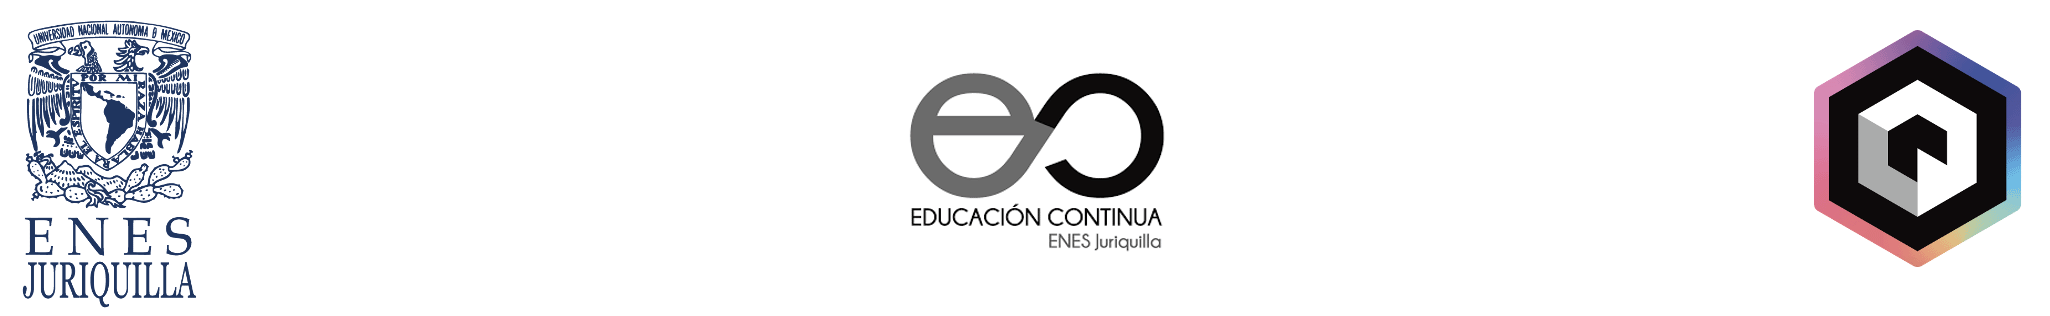

##Nota: Usar si cargamos los zip desde nuestra laptop

In [ ]:
#! unzip -u /content/Imagenes_Val_Emociones.zip -d "/content/Val_Emociones"

In [ ]:
!unzip -u /content/MonitorFacialEmotion_Osito.zip -d "/content/MonitorFacialE_Osito"

unzip:  cannot find or open /content/MonitorFacialEmotion_Osito.zip, /content/MonitorFacialEmotion_Osito.zip.zip or /content/MonitorFacialEmotion_Osito.zip.ZIP.


##Para cargar el zip desde drive (con link)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -u /content/drive/MyDrive/ProyectoOsito/MonitorFacialEmotion_Osito_new.zip -d '/content/MonitorFacialE_Osito'
#Cambiar la primera ruta para la carpeta de drive en la que está el zip

Archive:  /content/drive/MyDrive/ProyectoOsito/MonitorFacialEmotion_Osito_new.zip
  inflating: /content/MonitorFacialE_Osito/MonitorFacialEmotion_Osito/.gitattributes  
   creating: /content/MonitorFacialE_Osito/MonitorFacialEmotion_Osito/images/
  inflating: /content/MonitorFacialE_Osito/MonitorFacialEmotion_Osito/images/Emociones1.png  
  inflating: /content/MonitorFacialE_Osito/MonitorFacialEmotion_Osito/images/Emociones10.jpg  
  inflating: /content/MonitorFacialE_Osito/MonitorFacialEmotion_Osito/images/Emociones11.jpg  
  inflating: /content/MonitorFacialE_Osito/MonitorFacialEmotion_Osito/images/Emociones2.jpg  
  inflating: /content/MonitorFacialE_Osito/MonitorFacialEmotion_Osito/images/Emociones3.jpeg  
  inflating: /content/MonitorFacialE_Osito/MonitorFacialEmotion_Osito/images/Emociones4.jpeg  
  inflating: /content/MonitorFacialE_Osito/MonitorFacialEmotion_Osito/images/Emociones6.jpg  
  inflating: /content/MonitorFacialE_Osito/MonitorFacialEmotion_Osito/images/Emociones7.jpg

#Emotion Detection


In [ ]:
!pip install keras-utils

  Preparing metadata (setup.py) ... done
  Created wheel for keras-utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2631 sha256=ae5aad72b5b3bda7c1e0be9b7d2001b612d0d370b60f348cf27d57091108673d
  Stored in directory: /root/.cache/pip/wheels/5c/c0/b3/0c332de4fd71f3733ea6d61697464b7ae4b2b5ff0300e6ca7a
Successfully built keras-utils


In [ ]:
!pip install --upgrade git+https://github.com/broadinstitute/keras-resnet
import keras
import keras_resnet

  Cloning https://github.com/broadinstitute/keras-resnet to /tmp/pip-req-build-0v0_uydy
  Running command git clone --filter=blob:none --quiet https://github.com/broadinstitute/keras-resnet /tmp/pip-req-build-0v0_uydy
  Resolved https://github.com/broadinstitute/keras-resnet to commit 898a1ee417e940ff12bf73ad44c2aae88501771f
  Preparing metadata (setup.py) ... done
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=22139 sha256=9807720034011ca6be04ab3a516087a96a48587c803da0a126239695ff44cd1c
  Stored in directory: /tmp/pip-ephem-wheel-cache-7220cdve/wheels/54/0b/69/92ba1d0bb3df46face03c7826fed730afac3fecb2be4cd65d8
Successfully built keras-resnet


In [ ]:
from pathlib import Path
import cv2
import dlib
import sys
import numpy as np
import argparse
from contextlib import contextmanager
#import WideResNet
#from wide_resnet import WideResNet
from keras.utils import get_file
from keras.models import load_model
from keras.preprocessing.image import img_to_array

classifier = load_model('/content/MonitorFacialE_Osito/MonitorFacialEmotion_Osito/model/emotion_little_vgg_2.h5')
pretrained_model = "/content/MonitorFacialE_Osito/MonitorFacialEmotion_Osito/weights.28-3.73.hdf5"

In [ ]:
print(classifier)

In [ ]:
import logging
import sys
import numpy as np
from keras.models import Model
from tensorflow.keras.models import Model
from keras.layers import Input, Activation, add, Dense, Flatten, Dropout
from keras.layers import Conv2D, AveragePooling2D
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras import backend as K

sys.setrecursionlimit(2 ** 20)
np.random.seed(2 ** 10)


class WideResNet:
    def __init__(self, image_size, depth=16, k=8):
        self._depth = depth
        self._k = k
        self._dropout_probability = 0
        self._weight_decay = 0.0005
        self._use_bias = False
        self._weight_init = "he_normal"

        if K.image_data_format() == "channels_first":
            logging.debug("image_dim_ordering = 'th'")
            self._channel_axis = 1
            self._input_shape = (3, image_size, image_size)
        else:
            logging.debug("image_dim_ordering = 'tf'")
            self._channel_axis = -1
            self._input_shape = (image_size, image_size, 3)

    # Wide residual network http://arxiv.org/abs/1605.07146
    def _wide_basic(self, n_input_plane, n_output_plane, stride):
        def f(net):
            # format of conv_params:
            #               [ [kernel_size=("kernel width", "kernel height"),
            #               strides="(stride_vertical,stride_horizontal)",
            #               padding="same" or "valid"] ]
            # B(3,3): orignal <<basic>> block
            conv_params = [[3, 3, stride, "same"],
                           [3, 3, (1, 1), "same"]]

            n_bottleneck_plane = n_output_plane

            # Residual block
            for i, v in enumerate(conv_params):
                if i == 0:
                    if n_input_plane != n_output_plane:
                        net = BatchNormalization(axis=self._channel_axis)(net)
                        net = Activation("relu")(net)
                        convs = net
                    else:
                        convs = BatchNormalization(axis=self._channel_axis)(net)
                        convs = Activation("relu")(convs)

                    convs = Conv2D(n_bottleneck_plane, kernel_size=(v[0], v[1]),
                                          strides=v[2],
                                          padding=v[3],
                                          kernel_initializer=self._weight_init,
                                          kernel_regularizer=l2(self._weight_decay),
                                          use_bias=self._use_bias)(convs)
                else:
                    convs = BatchNormalization(axis=self._channel_axis)(convs)
                    convs = Activation("relu")(convs)
                    if self._dropout_probability > 0:
                        convs = Dropout(self._dropout_probability)(convs)
                    convs = Conv2D(n_bottleneck_plane, kernel_size=(v[0], v[1]),
                                          strides=v[2],
                                          padding=v[3],
                                          kernel_initializer=self._weight_init,
                                          kernel_regularizer=l2(self._weight_decay),
                                          use_bias=self._use_bias)(convs)

            # Shortcut Connection: identity function or 1x1 convolutional
            #  (depends on difference between input & output shape - this
            #   corresponds to whether we are using the first block in each
            #   group; see _layer() ).
            if n_input_plane != n_output_plane:
                shortcut = Conv2D(n_output_plane, kernel_size=(1, 1),
                                         strides=stride,
                                         padding="same",
                                         kernel_initializer=self._weight_init,
                                         kernel_regularizer=l2(self._weight_decay),
                                         use_bias=self._use_bias)(net)
            else:
                shortcut = net

            return add([convs, shortcut])

        return f


    # "Stacking Residual Units on the same stage"
    def _layer(self, block, n_input_plane, n_output_plane, count, stride):
        def f(net):
            net = block(n_input_plane, n_output_plane, stride)(net)
            for i in range(2, int(count + 1)):
                net = block(n_output_plane, n_output_plane, stride=(1, 1))(net)
            return net

        return f

#    def create_model(self):
    def __call__(self):
        logging.debug("Creating model...")

        assert ((self._depth - 4) % 6 == 0)
        n = (self._depth - 4) / 6

        inputs = Input(shape=self._input_shape)

        n_stages = [16, 16 * self._k, 32 * self._k, 64 * self._k]

        conv1 = Conv2D(filters=n_stages[0], kernel_size=(3, 3),
                              strides=(1, 1),
                              padding="same",
                              kernel_initializer=self._weight_init,
                              kernel_regularizer=l2(self._weight_decay),
                              use_bias=self._use_bias)(inputs)  # "One conv at the beginning (spatial size: 32x32)"

        # Add wide residual blocks
        block_fn = self._wide_basic
        conv2 = self._layer(block_fn, n_input_plane=n_stages[0], n_output_plane=n_stages[1], count=n, stride=(1, 1))(conv1)
        conv3 = self._layer(block_fn, n_input_plane=n_stages[1], n_output_plane=n_stages[2], count=n, stride=(2, 2))(conv2)
        conv4 = self._layer(block_fn, n_input_plane=n_stages[2], n_output_plane=n_stages[3], count=n, stride=(2, 2))(conv3)
        batch_norm = BatchNormalization(axis=self._channel_axis)(conv4)
        relu = Activation("relu")(batch_norm)

        # Classifier block
        pool = AveragePooling2D(pool_size=(8, 8), strides=(1, 1), padding="same")(relu)
        flatten = Flatten()(pool)
        predictions_g = Dense(units=2, kernel_initializer=self._weight_init, use_bias=self._use_bias,
                              kernel_regularizer=l2(self._weight_decay), activation="softmax",
                              name="pred_gender")(flatten)
        predictions_a = Dense(units=101, kernel_initializer=self._weight_init, use_bias=self._use_bias,
                              kernel_regularizer=l2(self._weight_decay), activation="softmax",
                              name="pred_age")(flatten)
        model = Model(inputs=inputs, outputs=[predictions_g, predictions_a])



        return model


def main():
    model = WideResNet(64)()
    model.summary()


if __name__ == '__main__':
    main()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 16)           432       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 16)           64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 64, 64, 16)           0         ['batch_normalization[0][0

### Detecting emotion of people in any Image

1/1 [==============================] - 1s 1s/step


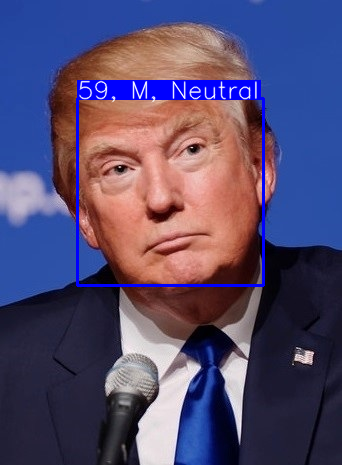

1/1 [==============================] - 0s 22ms/step


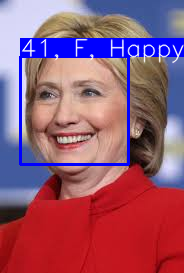

1/1 [==============================] - 0s 19ms/step


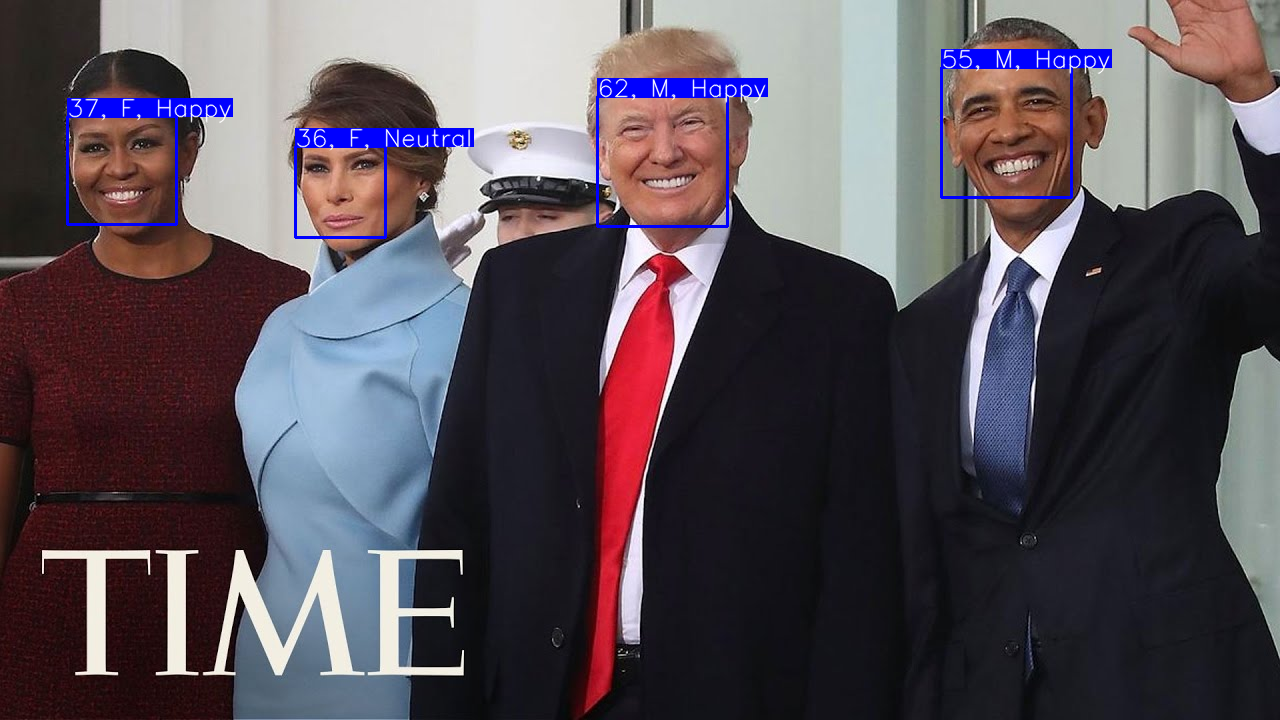

1/1 [==============================] - 0s 21ms/step


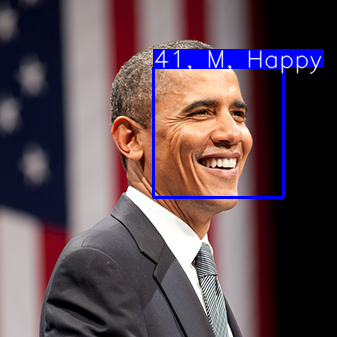

1/1 [==============================] - 0s 26ms/step


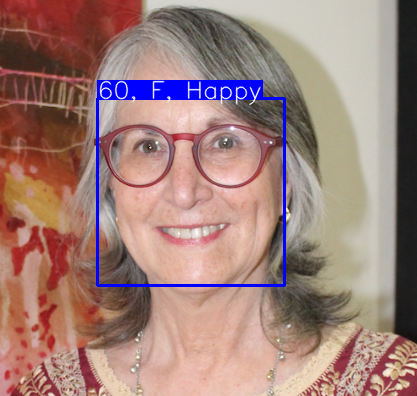

1/1 [==============================] - 0s 22ms/step


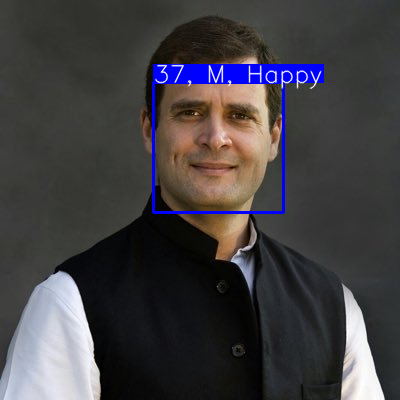

1/1 [==============================] - 0s 19ms/step


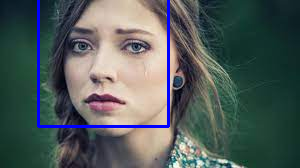

1/1 [==============================] - 0s 20ms/step


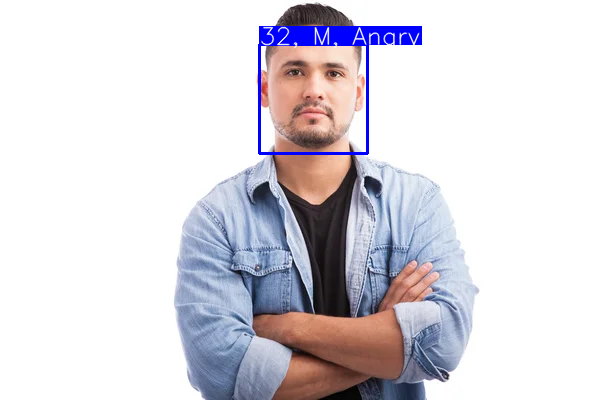

1/1 [==============================] - 0s 20ms/step


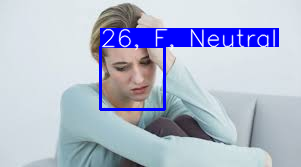

1/1 [==============================] - 0s 20ms/step


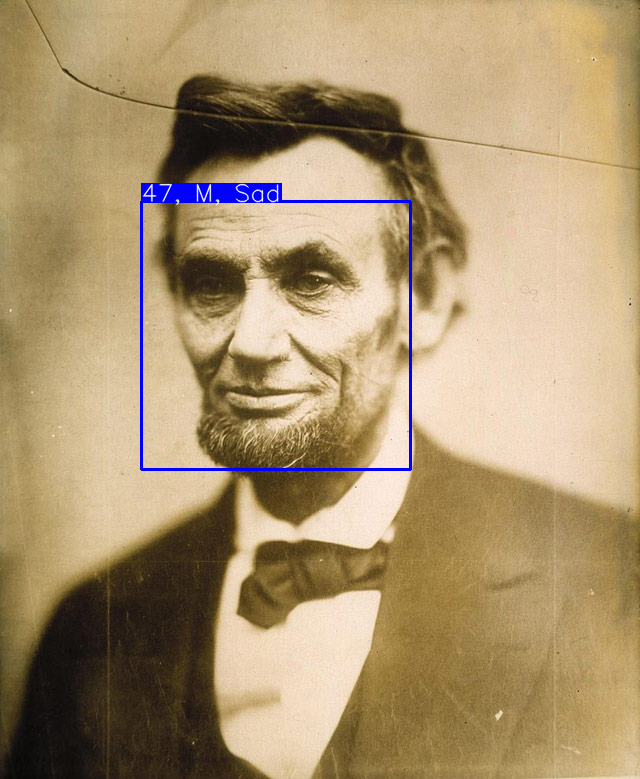

In [ ]:
from os import listdir
from os.path import isfile, join
from google.colab.patches import cv2_imshow
import os
import cv2
import numpy as np
# Define Image Path Here
image_path = "/content/MonitorFacialE_Osito/MonitorFacialEmotion_Osito/images"

modhash = 'fbe63257a054c1c5466cfd7bf14646d6'
emotion_classes = {0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Surprise'}

def draw_label(image, point, label, font=cv2.FONT_HERSHEY_SIMPLEX,
               font_scale=0.8, thickness=1):
    size = cv2.getTextSize(label, font, font_scale, thickness)[0]
    x, y = point
    cv2.rectangle(image, (x, y - size[1]), (x + size[0], y), (255, 0, 0), cv2.FILLED)
    cv2.putText(image, label, point, font, font_scale, (255, 255, 255), thickness, lineType=cv2.LINE_AA)


# Define our model parameters
depth = 16
k = 8
weight_file = None
margin = 0.4
image_dir = None

# Get our weight file
if not weight_file:
    weight_file = get_file("/content/MonitorFacialE_Osito/MonitorFacialEmotion_Osito/weights.28-3.73.hdf5", pretrained_model, cache_subdir="pretrained_models",
                           file_hash=modhash, cache_dir=Path(sys.argv[0]).resolve().parent)
# load model and weights
img_size = 64
model = WideResNet(img_size, depth=depth, k=k)()
model.load_weights(weight_file)

detector = dlib.get_frontal_face_detector()

image_names = [f for f in listdir(image_path) if isfile(join(image_path, f))]

for image_name in image_names:

    frame = cv2.imread("/content/MonitorFacialE_Osito/MonitorFacialEmotion_Osito/images/" + image_name)
    preprocessed_faces_emo = []

    input_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_h, img_w, _ = np.shape(input_img)
    detected = detector(frame, 1)
    faces = np.empty((len(detected), img_size, img_size, 3))

    preprocessed_faces_emo = []
    if len(detected) > 0:
        for i, d in enumerate(detected):
            x1, y1, x2, y2, w, h = d.left(), d.top(), d.right() + 1, d.bottom() + 1, d.width(), d.height()
            xw1 = max(int(x1 - margin * w), 0)
            yw1 = max(int(y1 - margin * h), 0)
            xw2 = min(int(x2 + margin * w), img_w - 1)
            yw2 = min(int(y2 + margin * h), img_h - 1)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
            # cv2.rectangle(img, (xw1, yw1), (xw2, yw2), (255, 0, 0), 2)
            faces[i, :, :, :] = cv2.resize(frame[yw1:yw2 + 1, xw1:xw2 + 1, :], (img_size, img_size))
            face =  frame[yw1:yw2 + 1, xw1:xw2 + 1, :]
            face_gray_emo = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            face_gray_emo = cv2.resize(face_gray_emo, (48, 48), interpolation = cv2.INTER_AREA)
            face_gray_emo = face_gray_emo.astype("float") / 255.0
            face_gray_emo = img_to_array(face_gray_emo)
            face_gray_emo = np.expand_dims(face_gray_emo, axis=0)
            preprocessed_faces_emo.append(face_gray_emo)

        # make a prediction for Age and Gender
        results = model.predict(np.array(faces))
        predicted_genders = results[0]
        ages = np.arange(0, 101).reshape(101, 1)
        predicted_ages = results[1].dot(ages).flatten()

        # make a prediction for Emotion
        emo_labels = []
        for i, d in enumerate(detected):
            preds = classifier.predict(preprocessed_faces_emo[i])[0]
            emo_labels.append(emotion_classes[preds.argmax()])

        # draw results
        for i, d in enumerate(detected):
            label = "{}, {}, {}".format(int(predicted_ages[i]),
                                        "F" if predicted_genders[i][0] > 0.4 else "M", emo_labels[i])
            draw_label(frame, (d.left(), d.top()), label)

    cv2_imshow(frame)
    filename = ".../output_images2/"+image_name
    cv2.imwrite(filename,frame)
    cv2.waitKey(0)

cv2.destroyAllWindows()

In [ ]:
 model.compile(optimizer='adam' ,                                                 # compilar modelo, usamos optimizador adam: se adapta a la pérdida que vamos obteniendo, pude hacer el gradiente más grande o pequeño
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Detection with webcam

In [ ]:
from os import listdir
from os.path import isfile, join
from google.colab.patches import cv2_imshow
import os
import cv2
import numpy as np
import urllib

url='http://10.10.56.249:8080/video' #Cambiar la IP a la de la cámara que vamos a usar

# Define Image Path Here
image_path = url

modhash = 'fbe63257a054c1c5466cfd7bf14646d6'
emotion_classes = {0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Surprise'}

def draw_label(image, point, label, font=cv2.FONT_HERSHEY_SIMPLEX,
               font_scale=0.8, thickness=1):
    size = cv2.getTextSize(label, font, font_scale, thickness)[0]
    x, y = point
    cv2.rectangle(image, (x, y - size[1]), (x + size[0], y), (255, 0, 0), cv2.FILLED)
    cv2.putText(image, label, point, font, font_scale, (255, 255, 255), thickness, lineType=cv2.LINE_AA)


# Define our model parameters
depth = 16
k = 8
weight_file = None
margin = 0.4
image_dir = None

# Get our weight file
if not weight_file:
    weight_file = get_file("/content/MonitorFacialE_Osito/MonitorFacialEmotion_Osito/weights.28-3.73.hdf5", pretrained_model, cache_subdir="pretrained_models",
                           file_hash=modhash, cache_dir=Path(sys.argv[0]).resolve().parent)
# load model and weights
img_size = 64
model = WideResNet(img_size, depth=depth, k=k)()
model.load_weights(weight_file)

detector = dlib.get_frontal_face_detector()

# Initialize Webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    imgResp=urllib.request.urlopen(url)
    imgNp=np.array(bytearray(imgResp.read()),dtype=np.uint8)
    img=cv2.imdecode(imgNp,-1)
    frame=img

    preprocessed_faces_emo = []
    input_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_h, img_w,_ = np.shape(input_img)
    detected = detector(frame, 1)
    faces = np.empty((len(detected), img_size, img_size, 3))

    preprocessed_faces_emo = []
    if len(detected) > 0:
        for i, d in enumerate(detected):
            x1, y1, x2, y2, w, h = d.left(), d.top(), d.right() + 1, d.bottom() + 1, d.width(), d.height()
            xw1 = max(int(x1 - margin * w), 0)
            yw1 = max(int(y1 - margin * h), 0)
            xw2 = min(int(x2 + margin * w), img_w - 1)
            yw2 = min(int(y2 + margin * h), img_h - 1)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
            # cv2.rectangle(img, (xw1, yw1), (xw2, yw2), (255, 0, 0), 2)
            faces[i, :, :, :] = cv2.resize(frame[yw1:yw2 + 1, xw1:xw2 + 1, :], (img_size, img_size))
            face =  frame[yw1:yw2 + 1, xw1:xw2 + 1, :]
            face_gray_emo = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            face_gray_emo = cv2.resize(face_gray_emo, (48, 48), interpolation = cv2.INTER_AREA)
            face_gray_emo = face_gray_emo.astype("float") / 255.0
            face_gray_emo = img_to_array(face_gray_emo)
            face_gray_emo = np.expand_dims(face_gray_emo, axis=0)
            preprocessed_faces_emo.append(face_gray_emo)

        # make a prediction for Age and Gender
        results = model.predict(np.array(faces))
        predicted_genders = results[0]
        ages = np.arange(0, 101).reshape(101, 1)
        predicted_ages = results[1].dot(ages).flatten()

        # make a prediction for Emotion
        emo_labels = []
        for i, d in enumerate(detected):
            preds = classifier.predict(preprocessed_faces_emo[i])[0]
            emo_labels.append(emotion_classes[preds.argmax()])

        # draw results
        for i, d in enumerate(detected):
            label = "{}, {}, {}".format(int(predicted_ages[i]),
                                        "F" if predicted_genders[i][0] > 0.4 else "M", emo_labels[i])
            draw_label(frame, (d.left(), d.top()), label)

    cv2_imshow(frame)
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break

cap.release()
cv2.destroyAllWindows()

### Detecting emotion of people in any Video

In [ ]:
from os import listdir
from os.path import isfile, join
from google.colab.patches import cv2_imshow
import numpy as np
import os
import cv2


modhash = 'fbe63257a054c1c5466cfd7bf14646d6'
emotion_classes = {0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Surprise'}

def draw_label(image, point, label, font=cv2.FONT_HERSHEY_SIMPLEX,
               font_scale=0.8, thickness=1):
    size = cv2.getTextSize(label, font, font_scale, thickness)[0]
    x, y = point
    cv2.rectangle(image, (x, y - size[1]), (x + size[0], y), (255, 0, 0), cv2.FILLED)
    cv2.putText(image, label, point, font, font_scale, (255, 255, 255), thickness, lineType=cv2.LINE_AA)


# Define our model parameters
depth = 16
k = 8
weight_file = None
margin = 0.4
image_dir = None

# Get our weight file
if not weight_file:
    weight_file = get_file("/content/MonitorFacialE_Osito/MonitorFacialEmotion_Osito/weights.28-3.73.hdf5", pretrained_model, cache_subdir="pretrained_models",
                           file_hash=modhash, cache_dir=Path(sys.argv[0]).resolve().parent)
# load model and weights
img_size = 64
model = WideResNet(img_size, depth=depth, k=k)()
model.load_weights(weight_file)

detector = dlib.get_frontal_face_detector()

# Initialize Webcam
cap = cv2.VideoCapture('/content/MonitorFacialE_Osito/MonitorFacialEmotion_Osito/videos/InfluyenEmocionesCuerpo.mp4')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_video1.mp4', fourcc, 10.0, (int(cap.get(3)), int(cap.get(4))))


while True:
    ret, frame = cap.read()


    preprocessed_faces_emo = []

    input_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_h, img_w, _ = np.shape(input_img)
    detected = detector(frame, 1)
    faces = np.empty((len(detected), img_size, img_size, 3))

    preprocessed_faces_emo = []
    if len(detected) > 0:
        for i, d in enumerate(detected):
            x1, y1, x2, y2, w, h = d.left(), d.top(), d.right() + 1, d.bottom() + 1, d.width(), d.height()
            xw1 = max(int(x1 - margin * w), 0)
            yw1 = max(int(y1 - margin * h), 0)
            xw2 = min(int(x2 + margin * w), img_w - 1)
            yw2 = min(int(y2 + margin * h), img_h - 1)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
            # cv2.rectangle(img, (xw1, yw1), (xw2, yw2), (255, 0, 0), 2)
            faces[i, :, :, :] = cv2.resize(frame[yw1:yw2 + 1, xw1:xw2 + 1, :], (img_size, img_size))
            face =  frame[yw1:yw2 + 1, xw1:xw2 + 1, :]
            face_gray_emo = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            face_gray_emo = cv2.resize(face_gray_emo, (48, 48), interpolation = cv2.INTER_AREA)
            face_gray_emo = face_gray_emo.astype("float") / 255.0
            face_gray_emo = img_to_array(face_gray_emo)
            face_gray_emo = np.expand_dims(face_gray_emo, axis=0)
            preprocessed_faces_emo.append(face_gray_emo)

        # make a prediction for Age and Gender
        results = model.predict(np.array(faces))
        predicted_genders = results[0]
        ages = np.arange(0, 101).reshape(101, 1)
        predicted_ages = results[1].dot(ages).flatten()

        # make a prediction for Emotion
        emo_labels = []
        for i, d in enumerate(detected):
            preds = classifier.predict(preprocessed_faces_emo[i])[0]
            emo_labels.append(emotion_classes[preds.argmax()])

        # draw results
        for i, d in enumerate(detected):
            label = "{}, {}, {}".format(int(predicted_ages[i]),
                                        "F" if predicted_genders[i][0] > 0.4 else "M", emo_labels[i])
            draw_label(frame, (d.left(), d.top()), label)

    out.write(frame)
    cv2_imshow(frame)
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break

cap.release()
out.release()
cv2.destroyAllWindows()